In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tifffile
from pathlib import Path

# Set up paths - update these to match your directory structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-1"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-1/Membrane_Adjusted"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    """
    Extract the sample ID from filenames like:
    - denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq005_membrane_mask
    - denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq005_Golgi_contrast_bg_tophat_golgi_adjusted_binary

    We want to extract everything before the specific component identifier
    """
    # Extract the base sample ID - everything up to seq### part
    parts = str(filename).split('_')
    seq_part = None
    for i, part in enumerate(parts):
        if part.startswith('seq'):
            seq_part = i
            break

    if seq_part is not None:
        # Include the seq### part in the sample ID
        base_id = '_'.join(parts[:seq_part+1])
        return base_id

    # Fallback method if seq### pattern is not found
    return None

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in
    component_folders = ['Membrane', 'Golgi_2']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all mask files in the component folder (may end with .tif, _mask, etc.)
        files = [f for f in os.listdir(component_dir) if
                any(ext in f.lower() for ext in ['.tif', 'mask', 'binary'])]
        print(f"Found {len(files)} mask files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                print(f"  Found {component} file: {file}")
                print(f"  Sample ID: {sample_id}")

                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                component_key = component.lower()
                file_dict[sample_id][component_key] = os.path.join(component_dir, file)
            else:
                print(f"  Couldn't extract sample ID from: {file}")

    # Print all extracted sample IDs and their components
    print("\nExtracted sample IDs:")
    for sample_id, components in file_dict.items():
        print(f"  Sample: {sample_id}")
        for comp, path in components.items():
            print(f"    {comp}: {os.path.basename(path)}")

    # Find samples that have all required components (Membrane and Golgi_Adjusted)
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have both membrane and golgi_adjusted data
        if 'membrane' in components and 'golgi_adjusted' in components:
            complete_samples.append(sample_id)
        else:
            missing = []
            if 'membrane' not in components:
                missing.append('membrane')
            if 'golgi_adjusted' not in components:
                missing.append('golgi_adjusted')
            print(f"  Sample {sample_id} is missing: {', '.join(missing)}")

    print(f"Found {len(complete_samples)} complete samples with membrane and golgi_adjusted data.")

    return file_dict, complete_samples

# Function to create adjusted membrane image (removing golgi areas)
def create_adjusted_membrane(membrane_img, golgi_img):
    """
    Create membrane image with pixels set to 0 where golgi are present
    """
    # Convert to binary if not already
    membrane_binary = membrane_img > 0
    golgi_binary = golgi_img > 0

    # Create the mask where membrane does not overlap with golgi
    membrane_without_golgi = membrane_binary.copy()
    membrane_without_golgi[golgi_binary] = 0

    # Convert back to the original data type of membrane_img
    if membrane_img.dtype == bool:
        return membrane_without_golgi
    else:
        return membrane_without_golgi.astype(membrane_img.dtype) * (membrane_img.max() or 1)

# Function to process a single sample
def process_sample(sample_id, file_dict, output_dir):
    print(f"\nProcessing sample: {sample_id}")

    # Load images
    try:
        membrane_img = io.imread(file_dict[sample_id]['membrane'])
        golgi_img = io.imread(file_dict[sample_id]['golgi_adjusted'])

        print(f"  Loaded membrane image: shape {membrane_img.shape}")
        print(f"  Loaded golgi_adjusted image: shape {golgi_img.shape}")
    except Exception as e:
        print(f"  Error loading images for sample {sample_id}: {e}")
        return False

    # Create adjusted membrane image
    adjusted_membrane = create_adjusted_membrane(membrane_img, golgi_img)

    # Create output filename, keeping the original filename pattern but adding "_golgi_removed"
    original_filename = os.path.basename(file_dict[sample_id]['membrane'])
    adjusted_filename = original_filename.replace('.tif', '_golgi_removed.tif')
    if '.tif' not in adjusted_filename:
        adjusted_filename += '_golgi_removed.tif'
    output_path = os.path.join(output_dir, adjusted_filename)

    # Save the adjusted membrane image
    try:
        tifffile.imwrite(output_path, adjusted_membrane)
        print(f"  Saved adjusted membrane to: {output_path}")
        return True
    except Exception as e:
        print(f"  Error saving adjusted membrane for sample {sample_id}: {e}")
        return False

# Find matching files
file_dict, complete_samples = find_matching_files(base_dir)

# Process all samples with complete data
successful_count = 0
failed_count = 0

print(f"\nProcessing {len(complete_samples)} samples...")

for i, sample_id in enumerate(complete_samples):
    print(f"\nSample {i+1}/{len(complete_samples)}: {sample_id}")
    result = process_sample(sample_id, file_dict, output_dir)
    if result:
        successful_count += 1
    else:
        failed_count += 1

print(f"\nProcessing complete!")
print(f"Successfully processed: {successful_count} samples")
print(f"Failed: {failed_count} samples")
print(f"Output directory: {output_dir}")

# Display a sample of the adjusted images for verification
if successful_count > 0:
    # Get a list of the adjusted membrane files
    adjusted_files = [f for f in os.listdir(output_dir) if f.endswith('_golgi_removed.tif')]

    if adjusted_files:
        # Display the first adjusted membrane image as an example
        sample_file = os.path.join(output_dir, adjusted_files[0])
        sample_img = io.imread(sample_file)

        plt.figure(figsize=(10, 10))
        plt.imshow(sample_img, cmap='gray')
        plt.title(f'Sample Adjusted Membrane (Golgi Removed): {adjusted_files[0]}')
        plt.axis('off')
        plt.show()

        print(f"Displayed sample adjusted membrane image: {adjusted_files[0]}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 16 mask files in Membrane folder.
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq002_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq002
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq003_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq003
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq004_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq004
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq005_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq005
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq006_membrane_mask.tif
  S

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 16 mask files in Membrane folder.
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq002_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq002
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq003_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq003
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq004_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq004
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq005_membrane_mask.tif
  Sample ID: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq005
  Found Membrane file: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq006_membrane_mask.tif
  S

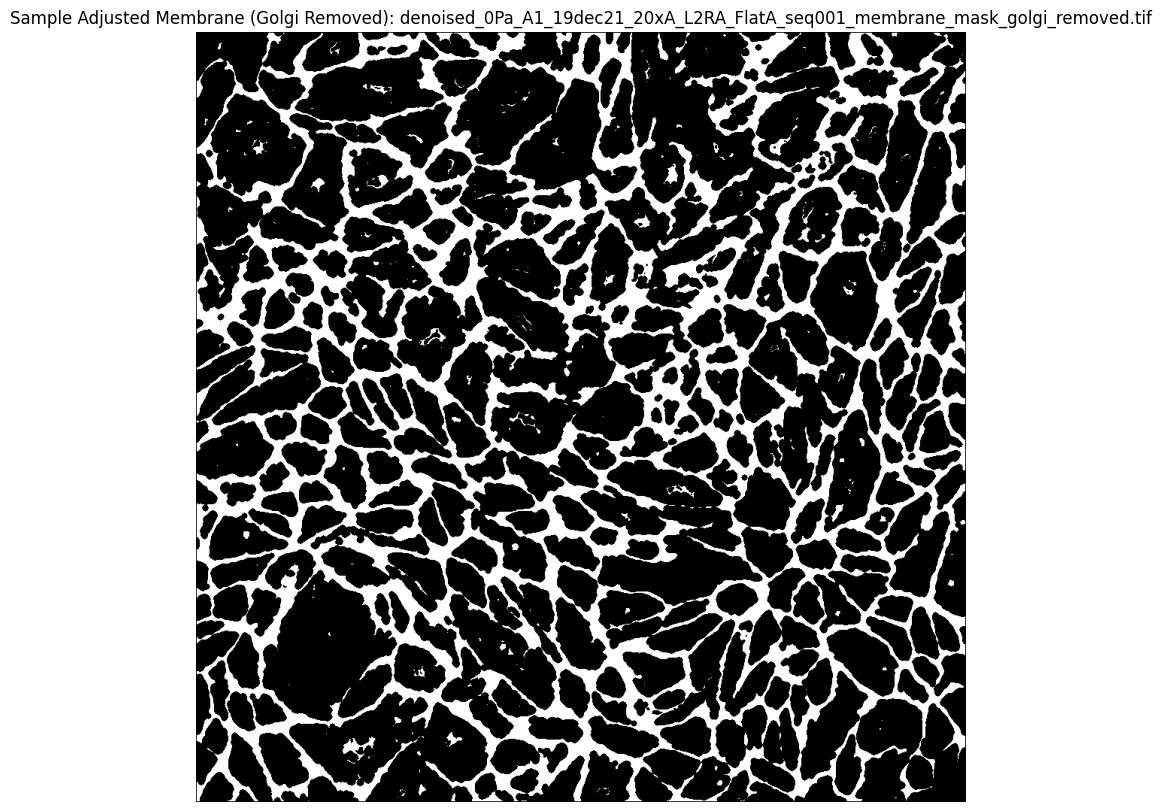

Displayed sample adjusted membrane image: denoised_0Pa_A1_19dec21_20xA_L2RA_FlatA_seq001_membrane_mask_golgi_removed.tif


In [ ]:
# Import necessary libraries
from google.colab import drive
drive.mount('/content/drive')

import os
import re
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import tifffile
from pathlib import Path

# Set up paths - update these to match your directory structure
base_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-1"
output_dir = "/content/drive/MyDrive/knowledge/University/Master/Thesis/Segmented/Static-A-1/Membrane_Adjusted"

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define function to extract sample ID from filenames
def extract_sample_id(filename):
    """
    Extract the sample ID from filenames like:
    - denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq005_membrane_mask
    - denoised_0Pa_A1_19dec21_40x_L2RA_FlatA_seq005_Golgi_contrast_bg_tophat_golgi_adjusted_binary

    We want to extract everything before the specific component identifier
    """
    # Extract the base sample ID - everything up to seq### part
    parts = str(filename).split('_')
    seq_part = None
    for i, part in enumerate(parts):
        if part.startswith('seq'):
            seq_part = i
            break

    if seq_part is not None:
        # Include the seq### part in the sample ID
        base_id = '_'.join(parts[:seq_part+1])
        return base_id

    # Fallback method if seq### pattern is not found
    return None

# Function to find matching files across different folders
def find_matching_files(base_dir):
    # Define component folders to look in
    component_folders = ['Membrane', 'Golgi_2']

    # Dictionary to store file paths for each sample and component
    file_dict = {}

    # Scan through each component folder
    for component in component_folders:
        component_dir = os.path.join(base_dir, component)
        if not os.path.exists(component_dir):
            print(f"Warning: {component_dir} does not exist.")
            continue

        # Get all mask files in the component folder (may end with .tif, _mask, etc.)
        files = [f for f in os.listdir(component_dir) if
                any(ext in f.lower() for ext in ['.tif', 'mask', 'binary'])]
        print(f"Found {len(files)} mask files in {component} folder.")

        for file in files:
            # Extract the sample ID from the filename
            sample_id = extract_sample_id(file)
            if sample_id:
                print(f"  Found {component} file: {file}")
                print(f"  Sample ID: {sample_id}")

                if sample_id not in file_dict:
                    file_dict[sample_id] = {}

                # Store the full path to the file
                component_key = component.lower()
                file_dict[sample_id][component_key] = os.path.join(component_dir, file)
            else:
                print(f"  Couldn't extract sample ID from: {file}")

    # Print all extracted sample IDs and their components
    print("\nExtracted sample IDs:")
    for sample_id, components in file_dict.items():
        print(f"  Sample: {sample_id}")
        for comp, path in components.items():
            print(f"    {comp}: {os.path.basename(path)}")

    # Find samples that have both membrane and golgi_2 data (instead of golgi_adjusted)
    complete_samples = []
    for sample_id, components in file_dict.items():
        # Check if we have both membrane and golgi_2 data
        if 'membrane' in components and 'golgi_2' in components:
            complete_samples.append(sample_id)
        else:
            missing = []
            if 'membrane' not in components:
                missing.append('membrane')
            if 'golgi_2' not in components:
                missing.append('golgi_2')
            print(f"  Sample {sample_id} is missing: {', '.join(missing)}")

    print(f"Found {len(complete_samples)} complete samples with membrane and golgi_2 data.")

    return file_dict, complete_samples

# Function to create adjusted membrane image (removing golgi areas)
def create_adjusted_membrane(membrane_img, golgi_img):
    """
    Create membrane image with pixels set to 0 where golgi are present
    """
    # Convert to binary if not already
    membrane_binary = membrane_img > 0
    golgi_binary = golgi_img > 0

    # Create the mask where membrane does not overlap with golgi
    membrane_without_golgi = membrane_binary.copy()
    membrane_without_golgi[golgi_binary] = 0

    # Convert back to the original data type of membrane_img
    if membrane_img.dtype == bool:
        return membrane_without_golgi
    else:
        return membrane_without_golgi.astype(membrane_img.dtype) * (membrane_img.max() or 1)

# Function to process a single sample
def process_sample(sample_id, file_dict, output_dir):
    print(f"\nProcessing sample: {sample_id}")

    # Load images
    try:
        membrane_img = io.imread(file_dict[sample_id]['membrane'])
        golgi_img = io.imread(file_dict[sample_id]['golgi_2'])  # Changed from 'golgi_adjusted' to 'golgi_2'

        print(f"  Loaded membrane image: shape {membrane_img.shape}")
        print(f"  Loaded golgi_2 image: shape {golgi_img.shape}")
    except Exception as e:
        print(f"  Error loading images for sample {sample_id}: {e}")
        return False

    # Create adjusted membrane image
    adjusted_membrane = create_adjusted_membrane(membrane_img, golgi_img)

    # Create output filename, keeping the original filename pattern but adding "_golgi_removed"
    original_filename = os.path.basename(file_dict[sample_id]['membrane'])
    adjusted_filename = original_filename.replace('.tif', '_golgi_removed.tif')
    if '.tif' not in adjusted_filename:
        adjusted_filename += '_golgi_removed.tif'
    output_path = os.path.join(output_dir, adjusted_filename)

    # Save the adjusted membrane image
    try:
        tifffile.imwrite(output_path, adjusted_membrane)
        print(f"  Saved adjusted membrane to: {output_path}")
        return True
    except Exception as e:
        print(f"  Error saving adjusted membrane for sample {sample_id}: {e}")
        return False

# Find matching files
file_dict, complete_samples = find_matching_files(base_dir)

# Process all samples with complete data
successful_count = 0
failed_count = 0

print(f"\nProcessing {len(complete_samples)} samples...")

for i, sample_id in enumerate(complete_samples):
    print(f"\nSample {i+1}/{len(complete_samples)}: {sample_id}")
    result = process_sample(sample_id, file_dict, output_dir)
    if result:
        successful_count += 1
    else:
        failed_count += 1

print(f"\nProcessing complete!")
print(f"Successfully processed: {successful_count} samples")
print(f"Failed: {failed_count} samples")
print(f"Output directory: {output_dir}")

# Display a sample of the adjusted images for verification
if successful_count > 0:
    # Get a list of the adjusted membrane files
    adjusted_files = [f for f in os.listdir(output_dir) if f.endswith('_golgi_removed.tif')]

    if adjusted_files:
        # Display the first adjusted membrane image as an example
        sample_file = os.path.join(output_dir, adjusted_files[0])
        sample_img = io.imread(sample_file)

        plt.figure(figsize=(10, 10))
        plt.imshow(sample_img, cmap='gray')
        plt.title(f'Sample Adjusted Membrane (Golgi Removed): {adjusted_files[0]}')
        plt.axis('off')
        plt.show()

        print(f"Displayed sample adjusted membrane image: {adjusted_files[0]}")